<a href="https://www.kaggle.com/code/incicelik/a-b-testing?scriptVersionId=131560039" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### What is A/B Testing?

# What is A/B Testing?

A/B Testing is a statistical method for hypotesis testing, a statistical inference.
A/B Testing is essential if you want to understand how your users (clients) are engaged in your services or how you can boost your revenue.

Recently it's very popular in e-commerce area and user expericence research.

A/B Testing is basically consisted of these following steps:
* Comparing Two Population Means (Independent Two Samples T Test)
*        - Parametric comparison
*        - Non-Parametric comparison
* Comparing Two Ratios From Two Samples (Proportions Z Test)
* Comparing Means of More Than Two Populations (ANOVA)

## The Data

In this post we will be looking into the data of an e-commerce website.

This website wants to apply a new method and wants compare if there is a difference between old and new method in terms of various indicators regarding the clients.

* 1st method: maximum bidding. (Control Group)
* 2nd method: average bidding. (Test Group)

## Variables:
* Impression – Number of ad views
* Click – Number of clicks through the ads
* Purchase – Number of purchases after clients clicked on the ads.
* Earning - Revenue through purchases

We will be focusing on this business problem in order to compare purchases, not earnings.

## Data Preparation

In [1]:
!pip install openpyxl
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from scipy.stats import ttest_ind
from scipy.stats import shapiro
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, pearsonr, spearmanr, kendalltau, f_oneway, kruskal
from statsmodels.stats.proportion import proportions_ztest

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

     |████████████████████████████████| 249 kB 7.8 MB/s            


In [2]:
df_control = pd.read_excel("../input/ab-testing/ab_testing.xlsx", sheet_name="Control Group")
df_test = pd.read_excel("../input/ab-testing/ab_testing.xlsx", sheet_name="Test Group")

Shape of datasets

In [3]:
# Both datasets have 40 observations & 4 variables
df_control.shape
df_test.shape

(40, 4)

Missing value check

In [4]:
df_control.isnull().values.any()
df_test.isnull().values.any()

False

# Descriptive Statistics

In [5]:
df_control.describe().T

,count,mean,std,min,25%,50%,75%,max
Impression,40.00000,101711.44907,20302.15786,45475.94296,85726.69035,99790.70108,115212.81654,147539.33633
Click,40.00000,5100.65737,1329.98550,2189.75316,4124.30413,5001.22060,5923.80360,7959.12507
Purchase,40.00000,550.89406,134.10820,267.02894,470.09553,531.20631,637.95709,801.79502
Earning,40.00000,1908.56830,302.91778,1253.98952,1685.84720,1975.16052,2119.80278,2497.29522


In [6]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Impression,40.00000,120512.41176,18807.44871,79033.83492,112691.97077,119291.30077,132050.57893,158605.92048
Click,40.00000,3967.54976,923.09507,1836.62986,3376.81902,3931.35980,4660.49791,6019.69508
Purchase,40.00000,582.10610,161.15251,311.62952,444.62683,551.35573,699.86236,889.91046
Earning,40.00000,2514.89073,282.73085,1939.61124,2280.53743,2544.66611,2761.54540,3171.48971


* Control group: Impression mean: 101.711, Click mean: 5100, Purchase mean: 550.9, Earning mean: 1908.5
* Test group: Impression mean: 120.512, Click mean: 3967.5, Purchase mean: 582, Earning mean: 2514.8

Purchase Confidence Interval

In [7]:
sms.DescrStatsW(df_control["Purchase"]).tconfint_mean()

(508.0041754264924, 593.7839421139709)

In [8]:
sms.DescrStatsW(df_test["Purchase"]).tconfint_mean()

(530.5670226990062, 633.6451705979289)

* Control group: Purchase Interval 508 - 593.8
* Test group: Purchase Interval 530.6 - 633.6
    
Although "Control" group have higher avg. number of clicks, "Test" group seems to have higher avg. purchase & higher avg. earnings.

To better understand the situation we need to conduct a statistical test.

# Following these steps for AB testing:
* 1.step: Check if the data has normal distribution.
* 2.step: Check if the data has variance homogeneity.
* 3.step: Depending on the test results mentioned above, deciding the right test for comparison.
    * If it has normal distribution & variance homogeneity: Two independent samples t test (Parametric)
    * If not: Mannwhitneyu Test (non-parametric)

# Focusing on PURCHASE - Assumption Check

**1.Step: Normal Distribution Control:**

H0 : Purchase is normally distributed.

H1 : Purchase is not normally distributed.

In [9]:
test_stat, pvalue = shapiro(df_control["Purchase"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 0.9773, p-value = 0.5891


p_value = 0.5891 > 0.05 (significance) So, we cannot reject the H0. "Purchase" is distributed normally in control data.

In [10]:
test_stat, pvalue = shapiro(df_test["Purchase"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 0.9589, p-value = 0.1541


p_value = 0.1541 > 0.05 (significance) So, we cannot reject the H0. "Purchase" is distributed normally in test data.

**2.Step: Assumption of Homogeneity of Variance:**

H0: Purchase variances are equal

H1: Purchase variances are not equal

In [11]:
test_stat, pvalue = levene(df_control["Purchase"],
                           df_test["Purchase"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 2.6393, p-value = 0.1083


p_value = 0.1083 > 0.05 So, we cannot reject the H0. "Purchase" has equal variances.

**3.Step: As we verified the normal distribution and variance homogeneity, we'll apply the parametric test (two-independent sample t-test)**



Setting the hypotesis test (The purpose)

H0: There is no significant difference between average purchase of Control and Test populations.

H0: There is statistically significant difference between average purchase of Control and Test populations

In [12]:
test_stat, pvalue = ttest_ind(df_control["Purchase"],
                              df_test["Purchase"],
                              equal_var=True)

print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = -0.9416, p-value = 0.3493


p_value = 0.35 > 0.05 So, we cannot reject the H0. There is no statistically significant difference between two populations in terms of average purchase.


Let's see the purchase distribution on the plot

<AxesSubplot:ylabel='Density'>

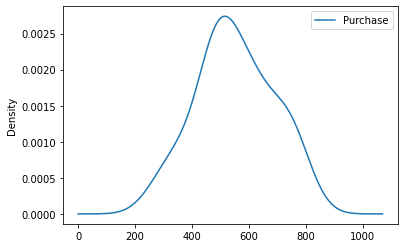

In [13]:
df_control['Purchase'].plot(kind='kde', legend=True)

<AxesSubplot:ylabel='Density'>

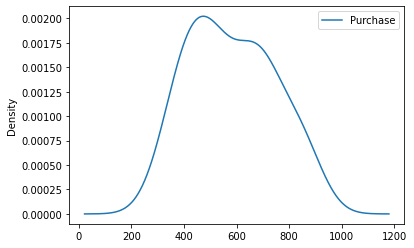

In [14]:
df_test['Purchase'].plot(kind='kde', legend=True)

# Conclusions (Communication)
In terms of average "purchase" there is no statistical difference between control and test groups with 95% confidence interval.


# Recommendations

* Both control and test data has 40 observations. More data will help to get more accurate information about the impact of chosen method on number of purchases.
* These comparisons can be conducted using more & various variables such as click / impression or purchase / impression


Thank you for reading... I appreciate if you upvote my notebook.

With support of [VBO](https://www.veribilimiokulu.com/)